## Recovery of continuous 3D refractive index maps from discrete intensity-only measurements using neural fields

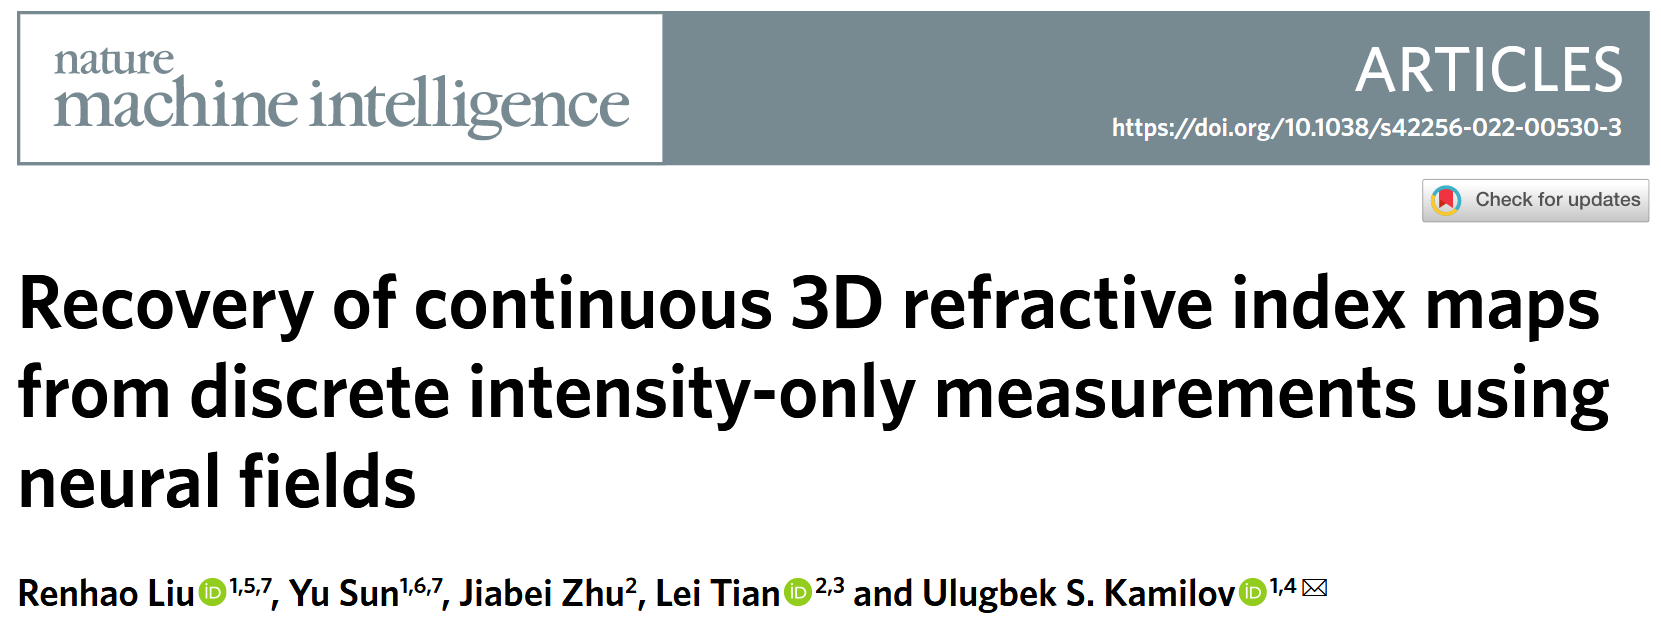

Github Repo: https://github.com/wustl-cig/DeCAF, 
Corresponding code: ../../../../code/NeRF_optics/DeCAF-master/predict.py

## 2. Background

Imaging biological samples without labeling or staining is crucial in biophotonics and quantitative phase imaging. One core technique, **Intensity Diffraction Tomography (IDT)**, reconstructs the 3D **Refractive Index (RI)** distribution of a sample by capturing 2D intensity images under varied illuminations.

In IDT, the input consists of a series of 2D intensity-only measurements acquired by illuminating the sample from multiple angles using an LED array. These measurements capture how the sample scatters light but lack any phase information. The goal is to reconstruct a 3D complex-valued RI volume, where each spatial location $(x, y, z)$ has a real part representing optical phase delay and an imaginary part corresponding to absorption.

This task is fundamentally challenging due to two key limitations: First, cameras only record intensity $I = |E|^2$, not the optical field $E$ itself, leading to a loss of phase information. Second, because illumination angles are restricted to a narrow range, the 3D Fourier space is undersampled along the axial ($z$) direction—a phenomenon known as the missing-cone problem—which causes artefacts and axial blur in the reconstruction.

Understanding what goes in (2D intensities) and what comes out (3D RI map) is essential because it frames IDT as an **inverse problem**. This guides how models are designed: the forward model predicts measurable intensities from a hypothetical RI volume, and learning aims to find an RI that best explains the actual measurements. Without knowing this input-output relationship, it's impossible to justify or optimize any computational reconstruction method.



### 3. Core Idea of DeCAF
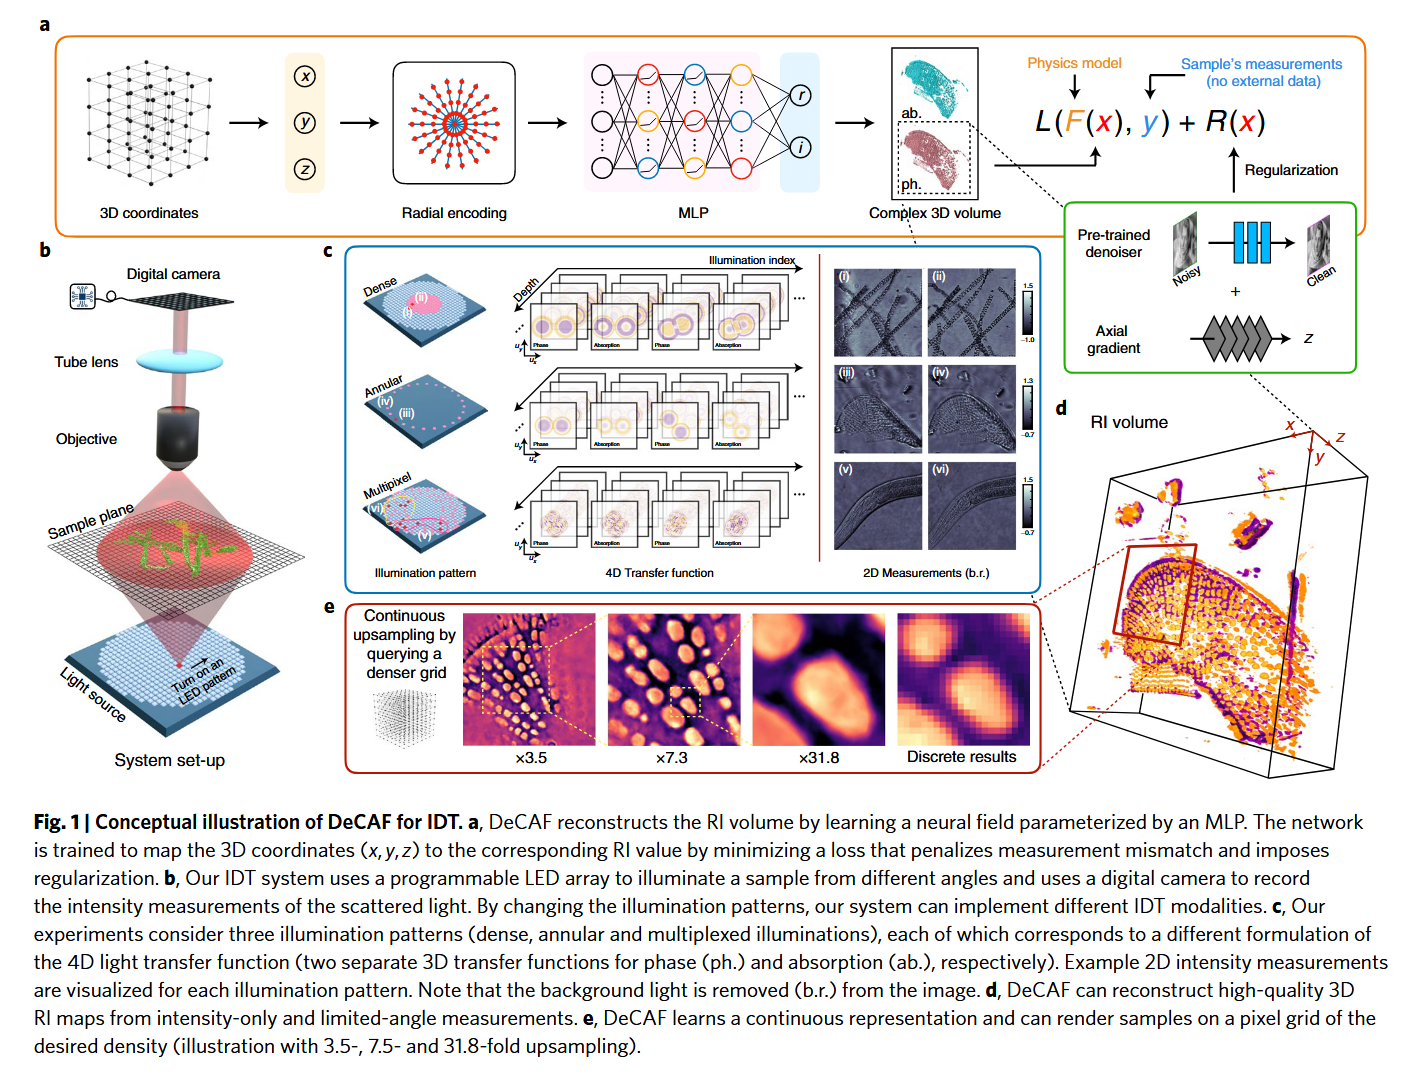
DeCAF is a self-supervised reconstruction method that learns a **continuous 3D refractive index (RI) volume** directly from **intensity-only 2D images** captured under multiple illuminations. It requires no ground-truth RI maps.

**Input:** a set of intensity measurements $y_\rho$ (2D images)  
**Output:** a continuous complex-valued RI field $n(x, y, z)$  
**Forward model:** a linear IDT model approximated as $y_\rho \approx A_\rho \Delta \epsilon$ (Eq. (3) in paper), where $\Delta \epsilon$ is the complex permittivity contrast

DeCAF represents the RI field using a **coordinate-based MLP** $M_\phi$, which takes spatial coordinates $(x, y, z)$ and predicts the corresponding $\Delta \epsilon_{\text{re}}, \Delta \epsilon_{\text{im}}$:

$$
(x, y, z) \xrightarrow{M_\phi} \Delta \epsilon
$$

From $\Delta \epsilon$, the RI values are derived via (Eq. (4)):

$$
n_{\text{re}} = \sqrt{\frac{1}{2} \left( n_0^2 + \Delta \epsilon_{\text{re}} + \sqrt{(n_0^2 + \Delta \epsilon_{\text{re}})^2 + \Delta \epsilon_{\text{im}}^2} \right)}
$$

$$
n_{\text{im}} = \frac{\Delta \epsilon_{\text{im}}}{2 \cdot n_{\text{re}}}
$$

**Training objective** (Eq. (1)):  
Find $\phi^*$ to minimize the measurement loss and regularization:

$$
\phi^* = \arg\min_\phi \left\{ \mathcal{L}(F(M_\phi(c)), y_\rho) + \mathcal{R}(M_\phi(c)) \right\}
$$

This setup makes DeCAF a test-time trained **implicit neural representation (INR)** method — the MLP serves as both the model and regularizer, optimized per sample using only the physical forward model.

## 3. Contributions of the Paper

- Introduced **DeCAF**, a test-time self-supervised method using neural fields for 3D RI reconstruction from intensity-only data.
- Designed a novel **radial encoding** to improve neural field performance in the x–y plane.
- Combined **implicit (MLP)** and **explicit (CNN denoiser)** regularization for enhanced reconstruction.
- Achieved **artefact-free RI maps** that significantly reduce missing-cone distortions and outperform baselines like Tikhonov and SIMBA.
- Demonstrated **continuous spatial representation** and super-resolution sampling capability without retraining.



## 4. References

1. Liu, R., Sun, Y., Zhu, J., Tian, L., & Kamilov, U. S. (2022). Recovery of continuous 3D refractive index maps from discrete intensity-only measurements using neural fields. *Nature Machine Intelligence*, 4, 781–791. https://doi.org/10.1038/s42256-022-00530-3  
2. Park, Y., Depeursinge, C., & Popescu, G. (2018). Quantitative phase imaging in biomedicine. *Nature Photonics*, 12(10), 578–589.  
3. Sitzmann, V., et al. (2020). Implicit neural representations with periodic activation functions. *NeurIPS*, 7462–7473.  
4. Wu, Z., et al. (2020). SIMBA: Scalable inversion in optical tomography using deep denoising priors. *IEEE JSTSP*, 14(6), 1163–1175.  


In [1]:
import os
import sys
print("Current working directory:", os.getcwd())
target_path = os.path.abspath(os.path.join(os.getcwd(), "../../../code/NeRF_optics/DeCAF-master"))
print("Appending path:", target_path)
sys.path.insert(0, target_path)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import h5py
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
import time
import numpy as np
from absl import app, flags
import imageio
from PIL import Image

from model.model import Model
from model.provider import DecafEndToEndProvider

FLAGS = flags.FLAGS
from absl import flags
import sys

FLAGS = flags.FLAGS

# input, output dirs.
flags.DEFINE_string("input_dir", "", "directory for Hreal & Himag")
flags.DEFINE_string("model_save_dir", "saved_model", "directory for saving model")
flags.DEFINE_string("result_save_dir", "result", "directory for saving results")

# Prediction config.
flags.DEFINE_float("z_min", -10, "minimum depth in micrometer")
flags.DEFINE_float("z_max", 16, "maximum depth in micrometer")
flags.DEFINE_float("z_train_delta", 0.5, "z delta in training data")
flags.DEFINE_float("z_delta", 0.1, "depth for each layer in micrometer")

flags.DEFINE_boolean(
    "partial_render",
    False,
    "Whether to render a subset of z. z_render_min, z_render_max only"
    "works if this is True",
)
flags.DEFINE_float("z_render_min", -20, "minimum depth to render in micrometer")
flags.DEFINE_float("z_render_max", 60, "maximum depth to render in micrometer")

flags.DEFINE_integer("row_render_min", 0, "minimum row to render in pixel")
flags.DEFINE_integer("row_render_max", 100, "maximum row to render in pixel")

flags.DEFINE_integer("col_render_min", 0, "minimum col to render in pixel")
flags.DEFINE_integer("col_render_max", 100, "maximum col to render in pixel")
flags.DEFINE_float("super_resolution_scale", 1, "super resolution scale")

# Render config.
flags.DEFINE_float("n0", 1.33, "n0 of the medium.")
flags.DEFINE_float("render_max", 0.02, "Range above average in rendering.")
flags.DEFINE_float("render_min", 0.02, "Range below average in rendering.")

if not FLAGS.is_parsed():
    sys.argv = [
        'predict.py',
        '--flagfile=../../../../code/NeRF_optics/DeCAF-master/datasets/Celegans_head/pred_config.txt'
    ]
    FLAGS(sys.argv)  # 显式触发解析


Current working directory: ../../../../Awesome-Computational-Imaging/chapters/Chapter08_DeCAF
Appending path: ../../../../code/NeRF_optics/DeCAF-master


#Permittivity to RI conversion

In [2]:
def perm2RI(er, ei, n0):
    """
    Description: This function converts the recovered object's permittivity contrast into refractive index values more
                 commonly found in the literature.
    :param er:  Scalar, 2D, or 3D matrix containing object's real permittivity contrast
    :param ei:  scalar, 2D, or 3D matrix containing object's imaginary permittivity contrast
    :param n0:  Scalar value containing value of imaging medium's refractive index value. in Air n0 = 1, in water n0 = 1.33
    :return: nr: Scalar, 2D, or 3D matrix of object's real refractive index value.
             ni: scalar, 2D, or 3D matrix of object's imaginary refractive index value.
    """
    print("er max: {}, er min:{}".format(er.max(), er.min()))
    nr = np.sqrt(0.5 * ((n0**2 + er) + np.sqrt((n0**2 + er)**2 + ei**2)))
    ni = np.divide(ei, 2 * nr)
    return nr, ni

# Loading files

In [3]:
data = h5py.File('../../../../code/NeRF_optics/DeCAF-master/datasets/Celegans_head/Celegans_head.mat', 'r')

#data = h5py.File(FLAGS.input_dir, 'r')
provider = DecafEndToEndProvider(data, [0, 1])

measurement shape: (2, 1000, 1000), Hreal shape: (2, 1, 41, 256, 256), Himag shape (2, 1, 41, 256, 256)
Using equal padding


# Inference

In [4]:
tic = time.perf_counter()

rows = int(provider.measurement_size)
cols = int(provider.measurement_size)

assert FLAGS.z_min < FLAGS.z_min + FLAGS.z_delta < FLAGS.z_max
key_zs = np.ceil((FLAGS.z_max + 1e-8 - FLAGS.z_min) / FLAGS.z_train_delta)
zs = np.ceil((FLAGS.z_max + 1e-8 - FLAGS.z_min) / FLAGS.z_delta)

if FLAGS.partial_render:
    scale = FLAGS.super_resolution_scale
    adjustment = 0.5 * (scale - 1) / scale
    rows_idx = np.linspace(
        FLAGS.row_render_min - adjustment,
        FLAGS.row_render_max - 1 + adjustment,
        num=int(
            (FLAGS.row_render_max - FLAGS.row_render_min)
            * FLAGS.super_resolution_scale
        ),
    )
    cols_idx = np.linspace(
        FLAGS.col_render_min - adjustment,
        FLAGS.col_render_max - 1 + adjustment,
        num=int(
            (FLAGS.col_render_max - FLAGS.col_render_min)
            * FLAGS.super_resolution_scale
        ),
    )

    assert FLAGS.z_min <= FLAGS.z_render_min <= FLAGS.z_render_max <= FLAGS.z_max

    key_z_min = (FLAGS.z_render_min - FLAGS.z_min) / FLAGS.z_train_delta
    partial_zs = np.ceil(
        (FLAGS.z_render_max + 1e-8 - FLAGS.z_render_min) / FLAGS.z_delta
    )
    key_z_max = (
        FLAGS.z_render_min + (partial_zs - 1) * FLAGS.z_delta - FLAGS.z_min
    ) / FLAGS.z_train_delta
    print(key_z_max)
    zs_idx = np.linspace(key_z_min, key_z_max, num=int(partial_zs))
else:
    rows_idx = np.arange(0, rows)
    cols_idx = np.arange(0, cols)
    zs_idx = np.linspace(0, key_zs - 1, num=int(zs))
r_mesh, z_mesh, c_mesh = np.meshgrid(cols_idx, zs_idx, rows_idx)

r_mesh = (r_mesh / rows)[..., np.newaxis] - 0.5
c_mesh = (c_mesh / cols)[..., np.newaxis] - 0.5
z_mesh = (z_mesh / key_zs)[..., np.newaxis] - 0.5
mesh_grid = np.concatenate((r_mesh, c_mesh, z_mesh), axis=-1) * 2

FLAGS.view_size = rows_idx.size
model = Model()
output_dir = FLAGS.result_save_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
_, recon = model.predict(FLAGS.model_save_dir, mesh_grid)
if FLAGS.partial_render:
    save_name = "prediction_result_zmax{}_zmin{}_zdelta{}_{}_{}_{}_{}_{}_to_{}_x{}".format(
        output_dir,
        FLAGS.z_max,
        FLAGS.z_min,
        FLAGS.z_delta,
        FLAGS.row_render_min,
        FLAGS.row_render_max,
        FLAGS.col_render_min,
        FLAGS.col_render_max,
        FLAGS.z_render_min,
        FLAGS.z_render_max,
        FLAGS.super_resolution_scale,
    )
    save_path = "{}/{}.mat".format(output_dir, save_name)
else:
    save_name = "prediction_result_zmax{}_zmin{}_zdelta{}".format(
        FLAGS.z_max,
        FLAGS.z_min,
        FLAGS.z_delta,
    )
    save_path = "{}/{}.mat".format(
        output_dir,
        save_name
    )
toc = time.perf_counter()
print("Inference ended in {:4} seconds.".format(toc - tic))
with h5py.File(save_path, "w") as h5_file:
    h5_file.create_dataset("recon", data=recon)

print("Prediction saved to {}".format(save_path))

INFO:tensorflow:Restoring parameters from ../../../../code/NeRF_optics/DeCAF-master/datasets/Celegans_head/trained_model/model
Inference ended in 18.539338678121567 seconds.
Prediction saved to ../../../../code/NeRF_optics/DeCAF-master/datasets/Celegans_head/inference//prediction_result_zmax10.0_zmin-10.0_zdelta0.25.mat


# Visualization

In [ ]:
ab = recon[:, :, :, 1]
ph = recon[:, :, :, 0]

visual = "n_re"
n_re, n_im = perm2RI(ph, ab, FLAGS.n0)
result = n_re

if visual == 'n_re':
    up = FLAGS.n0 + FLAGS.render_max;
    low = FLAGS.n0 + FLAGS.render_min;
else:
    up = FLAGS.render_max
    low = FLAGS.render_min
mu = (up + low) / 2;
w = up - low
result = np.clip(result, low, up)
result -= np.min(result)
result /= np.max(result)
result *= 255
result = result.astype(np.uint8)

def show_slice(z):
    plt.figure(figsize=(5, 5))
    plt.imshow(result[z].T, cmap='gray')
    plt.title(f"Predicted RI Slice z={z}")
    plt.axis('off')
    plt.show()

slider = widgets.IntSlider(min=0, max=result.shape[0]-1, step=1, value=0, description='z-slice')
widgets.interact(show_slice, z=slider)



video_frames =[]
image_dir = '{}/{}/'.format(output_dir, save_name)
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
for idx, img in enumerate(result):
    im = Image.fromarray(img.T)
    im.save(image_dir + 'img_{}.tif'.format(idx))
    video_frames.append(img.T)

f = '{}/{}.mp4'.format(output_dir, save_name)
# imageio.mimwrite(f, video_frames, fps=8, quality=7)
ext = os.path.splitext(f)[-1].lower()

if ext in [".mp4", ".gif", ".avi"]:
    imageio.mimwrite(f, video_frames, fps=8, quality=7)
else:
    imageio.mimwrite(f, video_frames)

er max: 0.053090374916791916, er min:-0.04331733286380768


interactive(children=(IntSlider(value=0, description='z-slice', max=80), Output()), _dom_classes=('widget-inte…

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x577ac80] Warning: data is not aligned! This can lead to a speed loss


: 